### Strong lensing optical depth

### $\frac{d^2 \tau}{dz_L d\sigma} = \frac{dn (\sigma, z_L)}{d\sigma} \sigma_{L} \frac{cdt}{dz_L} (1 + z)^3$

### $\frac{c dt}{dz_L} = \frac{c}{H(z_L)(1 + z_L)}$

$\sigma_{L} = \pi D_L^2(z_L) \theta_E^2(\sigma, z_L, z_s)$

For SIS lens, $\theta_{E, SIS} = 4\pi \left(\frac{\sigma}{c}\right)^2 \frac{D_{LS}}{D_S}$

### $\tau(z_s) = \int_0^{z_s} dz_L \int_0^\infty d\sigma \frac{d^2\tau}{dz_L d\sigma}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import math
import astropy.constants as const
from astropy.cosmology import Planck18 as cosmo
from scipy.integrate import quad, simpson

In [2]:
def dn_dsigma_bernardi2010(sigma, z_L, nu_n=-1.18, nu_nu=0.18, h=0.7):
    phi_star_0 = 2.099e-2 * (h/0.7)**3 * u.Mpc**-3 * (1 + z_L)**nu_n  # (h/0.7)^3 Mpc^-3
    sigma_star_0 = 113.78 * u.km / u.s * (1 + z_L)**nu_nu
    alpha = 0.94
    beta = 1.85
    coeff = beta / (math.gamma(alpha / beta) * sigma)
    exponent = - (sigma / sigma_star_0)**beta
    power_law = (sigma / sigma_star_0)**alpha
    return phi_star_0 * power_law * np.exp(exponent) * coeff

In [3]:
def d2tau_dzL_dsigma(sigma, z_L, z_s, lens_model='SIS'):
    dn_dsigma = dn_dsigma_bernardi2010(sigma, z_L)
    if lens_model == 'SIS':
        theta_E = 4 * np.pi * (sigma / const.c)**2 * (cosmo.angular_diameter_distance_z1z2(z_L, z_s) / cosmo.angular_diameter_distance(z_s))
    elif lens_model == 'SIE':
        # Placeholder for SIE model
        theta_E = 4 * np.pi * (sigma / const.c)**2 * (cosmo.angular_diameter_distance_z1z2(z_L, z_s) / cosmo.angular_diameter_distance(z_s))  # Modify as needed
    else:
        raise ValueError("Unsupported lens model")
    
    D_ls = cosmo.angular_diameter_distance_z1z2(z_L, z_s)
    D_s  = cosmo.angular_diameter_distance(z_s)
    D_l  = cosmo.angular_diameter_distance(z_L)

    theta_E = (4 * np.pi * (sigma / const.c)**2 * (D_ls / D_s)).decompose()
    sigma_lens = (np.pi * (D_l * theta_E)**2).to(u.Mpc**2)
    dl_dz = (const.c / cosmo.H(z_L)) * (1 + z_L)**2
    return dn_dsigma * sigma_lens * dl_dz

print(d2tau_dzL_dsigma(200*u.km/u.s, 0.5, 2.0))


0.004594846845129651 m s / km2


In [4]:
def integrand_logsigma(ln_sigma, z_L, z_s):
    sigma = np.exp(ln_sigma) * u.km / u.s
    val = sigma * d2tau_dzL_dsigma(sigma=sigma, z_L=z_L, z_s=z_s)
    return val.to_value(u.dimensionless_unscaled) #dimensionless


def tau(z_s, sigma_min=50*u.km/u.s, sigma_max=400*u.km/u.s, epsrel=1e-6, epsabs=1e-8):
    ln_sigma_min = np.log(sigma_min.to_value(u.km/u.s))
    ln_sigma_max = np.log(sigma_max.to_value(u.km/u.s))

    def inner_sigma(z_L):
        val, err = quad(integrand_logsigma, ln_sigma_min, ln_sigma_max, args=(z_L, z_s), epsrel=epsrel, epsabs=epsabs)
        return val

    tau_val, err = quad(inner_sigma, 0.0, z_s, epsrel=epsrel, epsabs=epsabs)

    return tau_val


In [5]:
print(d2tau_dzL_dsigma(200*u.km/u.s, 0.5, 2.0))
print(tau(2.0))

0.004594846845129651 m s / km2
0.0007215909869929351


In [6]:
from tqdm import tqdm

z_s_grid = np.linspace(0.1, 3.0, 30)
tau_grid = np.array([tau(z_s) for z_s in tqdm(z_s_grid)])


100%|██████████| 30/30 [00:05<00:00,  5.83it/s]


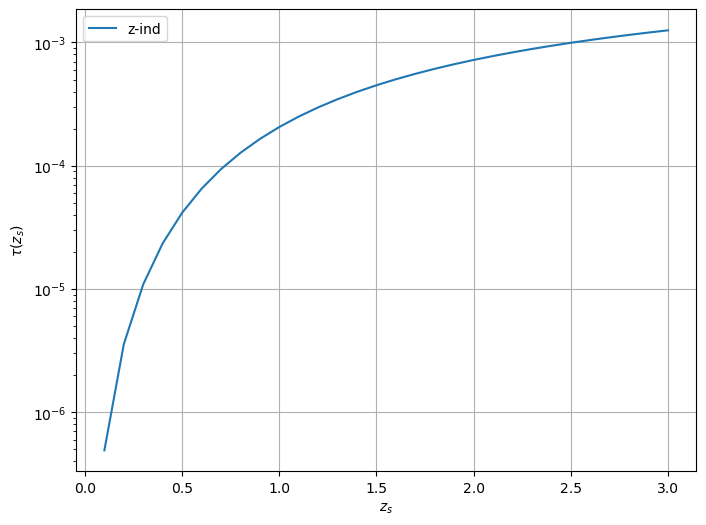

In [7]:
plt.figure(figsize=(8,6))
plt.plot(z_s_grid, tau_grid, label='z-ind')
plt.xlabel(r'$z_s$')
plt.ylabel(r'$\tau(z_s)$')
#plt.title('Strong Lensing Optical Depth as a Function of Source Redshift')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


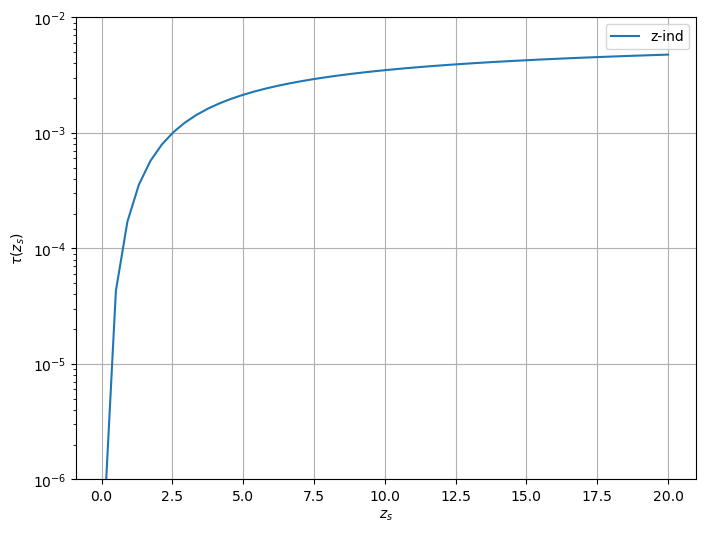

In [9]:
z_s_grid = np.linspace(0.1, 20, 50)
tau_grid = np.array([tau(z_s) for z_s in tqdm(z_s_grid)])

plt.figure(figsize=(8,6))
plt.plot(z_s_grid, tau_grid, label='z-ind')
plt.xlabel(r'$z_s$')
plt.ylabel(r'$\tau(z_s)$')
#plt.title('Strong Lensing Optical Depth as a Function of Source Redshift')
plt.yscale('log')
plt.ylim(1e-6, 1e-2)
plt.legend()
plt.grid()
plt.show()